In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import ase
import glob
import tqdm
import time
import scipy
import numba
import pickle
import numpy as np
import pandas as pd
import ase.io as aio
import seaborn as sns
import scipy.io as sio
import multiprocessing as mp
from matplotlib import colors
import matplotlib.pyplot as plt
import poremks.porosity as pore
from scipy.spatial import cKDTree
from collections import defaultdict
import poremks.correlations as corr
import poremks.grid_generator as gen
from poremks.helpers import write2vtk
from scipy.sparse.csgraph import dijkstra
from matplotlib.offsetbox import AnchoredText
from toolz.curried import pipe, curry, compose

In [3]:
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as spc
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform

from dtw import dtw
from fastdtw import fastdtw
from sklearn.manifold import MDS
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean


dist = compose(squareform, curry(pdist)(metric="correlation"))

def saver(fname, obj):
    with open(fname, "wb") as f:
        pickle.dump(obj, f)
        
def loader(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)
    
if not os.path.exists("Elemental_Radii.xlsx"):
    os.system("wget https://www.ccdc.cam.ac.uk/support-and-resources/ccdcresources/Elemental_Radii.xlsx")
    
    
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.figsize'] = [9.0, 6.0]
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

def hist_plot(x, title):
    ax = sns.distplot(x, rug=True, kde=False, hist=True, norm_hist=False)
    anc = AnchoredText("count: {}\nmin: {:1.3f}\nmax: {:1.3f}".format(len(x), np.min(x), np.max(x)), loc="upper right", frameon=False)
    ax.add_artist(anc)
    plt.title(title)
    plt.show()

def get_corr_labels(df, t=2.0):
    return pipe(df, 
                lambda x: 1 - dist(df.values), 
                curry(pdist)(metric="euclidean"), 
                curry(sch.linkage)(method="complete"),
                curry(sch.fcluster)(t=t, criterion="distance"))    
    
def get_rows(df, col, r_min, r_max):
    return df.loc[(df[col]>r_min) & (df[col]<r_max)]

def plot_corr(df, size=10, verbose=False):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    # Compute the correlation matrix for the received dataframe
    plt.figure(figsize=(size*1.3, size))
    corr = df.corr()
    # Plot the correlation matrix
    cax = sns.heatmap(corr, annot=verbose, cmap='RdYlGn')
    plt.show()
    
conv = curry(np.convolve)(mode="valid")
manhattan_distance = lambda x, y: np.abs(x - y)

def dtw_distance(x,y):
    return fastdtw(x, y, dist=manhattan_distance)[0]

def voc_distance(f1, f2):
    return conv(f1,f2).max()/np.sqrt(conv(f1,f1)[0] * conv(f2,f2)[0])

def dmatrix(paths1, paths2=None, func=dtw_distance):
    
    if paths2 is not  None:
        mat = np.zeros((len(paths1), len(paths2)))
        for i1, p1 in enumerate(paths1):
            for i2, p2 in enumerate(paths2):
                mat[i1, i2]= func(p1, p2)
    else:
        mat = np.zeros([len(paths1)]*2)
        for i1, p1 in enumerate(paths1):
            for i2, p2 in enumerate(paths1[i1:]):
                mat[i1, i1+i2]= func(p1, p2)     
        out = mat.T + mat
        mask = np.eye(out.shape[0],dtype=bool)
        out[mask] = mat[mask]
        mat = out
    return mat

@numba.njit()
def get_path_sublist(dist_list, tort_list, pld=2.0, trt=2.0, diff_trt = 0.1, diff_pld=0.1):
    dists = []
    torts = []
    for d, t in zip(dist_list, tort_list):
        if np.fabs(d.min()-pld/2) < diff_pld:
            if np.fabs(t-trt) < diff_trt:
                dists.append(d)
                torts.append(t)
    return dists, torts

In [4]:
np.printoptions(precision=2)
pd.set_option('precision',2)

In [5]:
df = pd.read_csv("csv/slabs_minEnergy.csv", index_col=0)
df.head(3)

,cif,pld,lcd,asa,av,psd mean,psd std,n_paths,paths mean,paths std,xdim,ydim,zdim,n_channels
0,"ABWff-[1,0,1]-L-0.732814_0-U-0.748843_0-ss-12....",2.34,5.23,3484.15,2197.53,1.12,0.52,858.0,2.11,0.51,10.6,25.9,14.3,1.0
1,"ABWff-[1,0,1]-L-0.732814_0-U-0.748843_0-ss-6.4...",2.48,5.23,1851.98,1252.34,1.18,0.54,900.0,3.78,1.55,10.6,25.8,7.9,1.0
2,"ACOff-[1,1,0]-L-0.674661_0-U-0.674735_0-ss-14....",3.46,5.48,7121.32,4907.14,1.14,0.58,8236.0,2.30,0.60,19.7,27.6,15.4,1.0


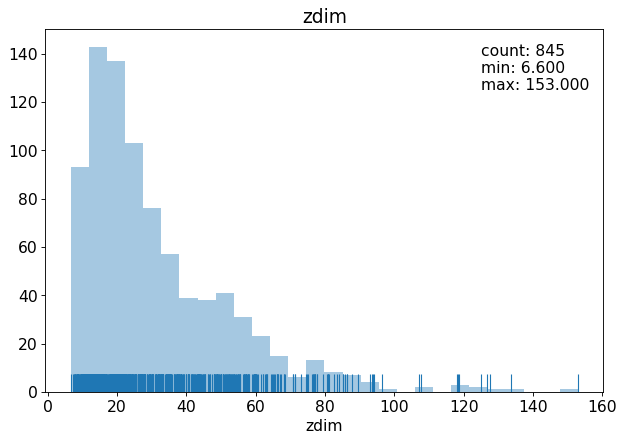

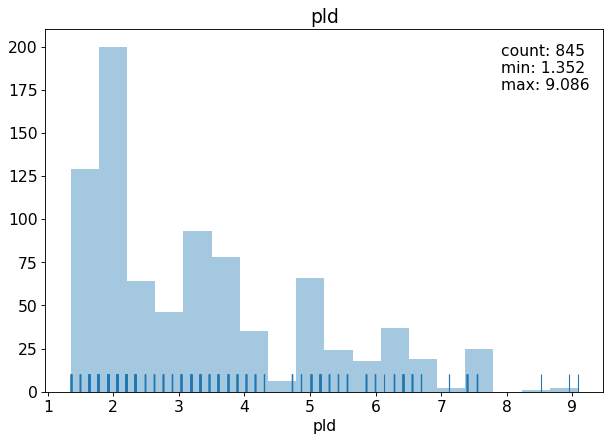

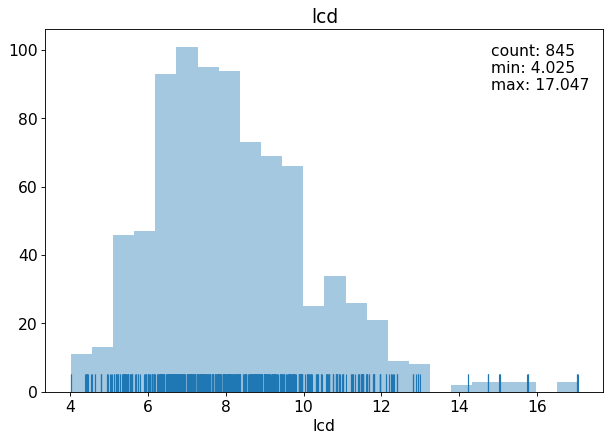

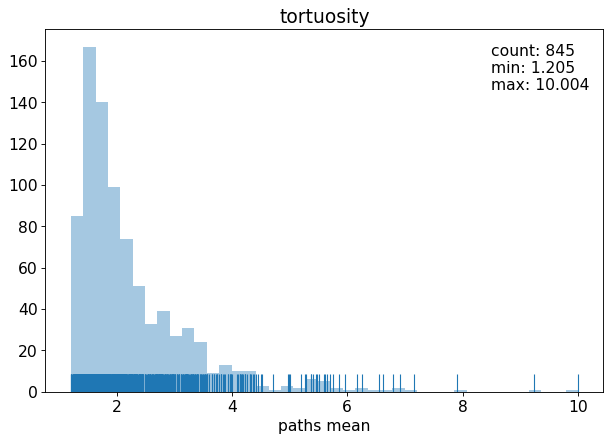

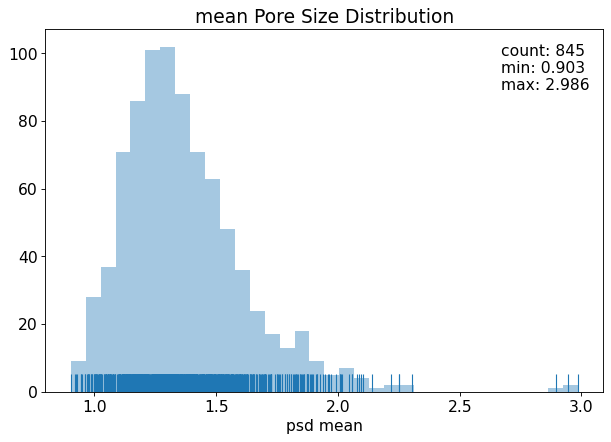

In [6]:
hist_plot(df["zdim"], title="zdim")
hist_plot(df["pld"], title="pld")
hist_plot(df["lcd"], title="lcd")
hist_plot(df["paths mean"], title="tortuosity")
hist_plot(df["psd mean"], title="mean Pore Size Distribution")

In [7]:
seed_structure = "BECff-[1,0,0]-L-0.379015_0-U-0.810225_0-ss-17.8292106027"

In [8]:
nn_metrics = ["pld", "lcd", "paths mean", "zdim"]
nn_coordinates = pipe(df[nn_metrics], lambda x: (x-x.mean())/x.std())
seed_coordinates = nn_coordinates[df["cif"] == seed_structure]
print(f"seed metrics: {seed_coordinates}")
tree = cKDTree(nn_coordinates)
# neighbors = tree.query_ball_point(seed_coordinates, 0.5)[0]
dists, neighbors = tree.query(seed_coordinates, k=10)
seed_indx = neighbors[0, 0]
df_sub = df.loc[neighbors[0]]
print("No. of structures in the subset: {}".format(len(df_sub)))

seed metrics:       pld   lcd  paths mean  zdim
101  1.84  0.45       -0.39 -0.55
No. of structures in the subset: 10


In [9]:
df[nn_metrics].describe()
df[nn_metrics].std() / df[nn_metrics].mean()
pipe(df[nn_metrics], lambda x: (x-x.mean())/x.std())

,pld,lcd,paths mean,zdim
0,-0.62,-1.45,-0.14,-0.81
1,-0.53,-1.45,1.45,-1.11
2,0.06,-1.34,0.04,-0.76
3,0.15,-1.30,1.05,-1.08
4,0.32,-0.14,-0.59,-0.09
...,...,...,...,...
840,-1.04,-1.36,-0.74,-0.09
841,-1.04,-1.36,-0.82,0.57
842,-0.87,-0.69,-0.50,-0.19
843,-0.87,-0.67,-0.71,0.62


In [10]:
df_sub[["cif",]+nn_metrics].head(3)

,cif,pld,lcd,paths mean,zdim
101,"BECff-[1,0,0]-L-0.379015_0-U-0.810225_0-ss-17....",6.41,9.13,1.85,19.8
320,"ISVff-[0,0,1]-L-0.094912_0-U-0.905124_0-ss-17....",6.55,9.04,1.99,19.8
355,"IWSff-[1,0,0]-L-0.107187_0-U-0.892873_0-ss-19....",6.55,9.12,2.16,21.1


In [11]:
df_sub.describe()

,pld,lcd,asa,av,psd mean,psd std,n_paths,paths mean,paths std,xdim,ydim,zdim,n_channels
count,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.00,10.0
mean,6.48,9.11,13550.13,12633.30,1.46,0.93,18687.90,1.95,0.36,28.73,29.49,23.24,1.0
std,0.39,0.56,6377.05,5744.30,0.09,0.09,30059.02,0.25,0.16,9.19,11.10,4.57,0.0
min,5.57,8.03,6791.94,6653.84,1.32,0.79,625.00,1.54,0.18,23.30,20.90,18.60,1.0
25%,6.41,9.06,8987.19,8489.32,1.40,0.87,1655.50,1.85,0.21,24.52,24.60,19.80,1.0
50%,6.55,9.13,11925.61,10358.37,1.47,0.93,2162.00,1.93,0.37,25.10,24.90,21.65,1.0
75%,6.66,9.50,16129.30,16557.91,1.53,1.00,16026.00,2.15,0.45,25.80,30.20,26.28,1.0
max,7.12,9.74,25925.62,24143.22,1.57,1.05,83144.00,2.33,0.61,52.70,58.20,32.50,1.0


In [12]:
## Load filepaths for path data
## path list
flist = sorted(glob.glob("likely-min/*.pkl"))
ciflist_paths = [f.split("/")[-1].split("_paths")[0].split("zz_")[-1] for f in flist]

strt = time.time()
paths = []
for _, cif in df_sub["cif"].items():
    try:
        ix = ciflist_paths.index(cif)
        paths.append(loader(flist[ix]))
    except Exception as err:
        print(cif)
print(f"time taken to upload nearest neighbor paths: {time.time()-strt:1.3f}")

time taken to upload nearest neighbor paths: 0.557


In [13]:
for path in paths:
    print(len(path["torts"]))

3922
2352
39283
170
272
20093
10710
14100
3760
3922


In [14]:
path = paths[0]
dists = path["dist_list"]
torts = path["torts"]
dists_dict = defaultdict(list)
for ix, t in enumerate(torts):
    dists_dict[int(np.floor(t*10))].append(dists[ix])
[(k, len(v)) for k, v in dists_dict.items()]

[(12, 25),
 (18, 472),
 (21, 264),
 (19, 202),
 (15, 407),
 (24, 30),
 (16, 385),
 (23, 120),
 (20, 132),
 (25, 58),
 (28, 5),
 (22, 299),
 (11, 166),
 (14, 299),
 (17, 902),
 (13, 122),
 (26, 19),
 (27, 8),
 (10, 6),
 (9, 1)]

* I need to be able to determine the canonical paths, for each of the PLDs or for each of the Torts

In [15]:
torts

array([1.22622807, 1.86685812, 2.15854967, ..., 1.61669522, 1.18677791,
       1.19182842])

In [17]:
plds = [np.min(d) for d in dists]

In [18]:
plds

[0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.5744563,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.7,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.781025,
 0.78

In [20]:
[np.min(d)*2. for d in dists_dict[12]]

[1.1489125490188599,
 3.0,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.399999976158142,
 1.399999976158142,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 1.9798990488052368,
 2.9529645442962646,
 2.6907248497009277,
 1.9798990488052368,
 1.9798990488052368]

In [99]:
# %%time
# strt = time.time()
# m0 = []
# for ix in range(len(dists)):
#     m0.append(dtw_distance(dists[0], dists[ix]))
# print(f"elpsd: {time.time()-strt:1.3e}")

elpsd: 2.576e+01
CPU times: user 25.7 s, sys: 0 ns, total: 25.7 s
Wall time: 25.8 s


In [75]:
# %%time
# strt = time.time()
# m1 = []
# for ix in range(len(dists)):
#     m1.append(voc_distance(dists[0], dists[ix]))
# print(f"elpsd: {time.time()-strt:1.3e}")

elpsd: 8.262e-02
CPU times: user 83 ms, sys: 0 ns, total: 83 ms
Wall time: 82.7 ms


In [30]:
k0 = 12

In [31]:
%%time
strt = time.time()
mat1 = dmatrix(dists_dict[k0], dists_dict[k0], func=voc_distance)
print(f"elpsd: {time.time()-strt:1.3e}")

elpsd: 1.778e-02
CPU times: user 18 ms, sys: 9.28 ms, total: 27.3 ms
Wall time: 17.9 ms


In [ ]:
# %%time
# strt = time.time()
# mat11 = dmatrix(dists_dict[12], dists_dict[12], func=voc_distance)
# print(f"elpsd: {time.time()-strt:1.3e}")

In [33]:
%%time
strt = time.time()
mat2 = dmatrix(dists_dict[k0], dists_dict[k0],func=dtw_distance)
print(f"elpsd: {time.time()-strt:1.3e}")

elpsd: 3.307e+00
CPU times: user 3.3 s, sys: 0 ns, total: 3.3 s
Wall time: 3.31 s


In [34]:
%%time
strt = time.time()
mat3 = dmatrix(dists_dict[12], func=dtw_distance)
print(f"elpsd: {time.time()-strt:1.3e}")

elpsd: 1.661e+00
CPU times: user 1.66 s, sys: 1.37 ms, total: 1.66 s
Wall time: 1.66 s


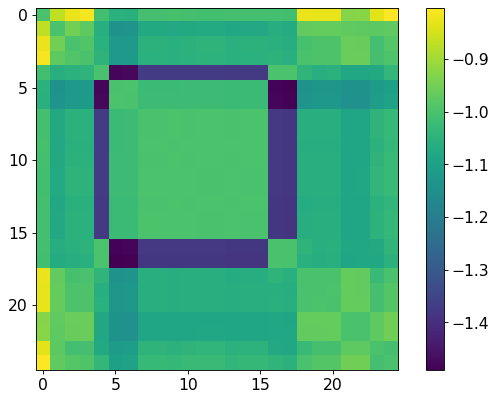

In [41]:
plt.imshow(-mat1)
plt.colorbar()
plt.show()

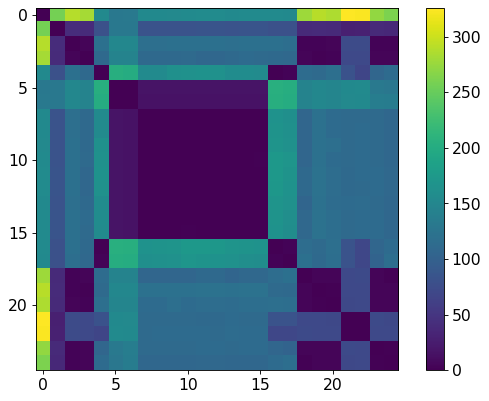

In [42]:
plt.imshow(mat3)
plt.colorbar()
plt.show()

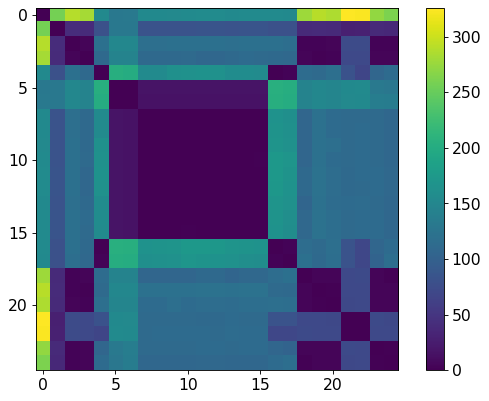

In [43]:
plt.imshow(mat3)
plt.colorbar()
plt.show()

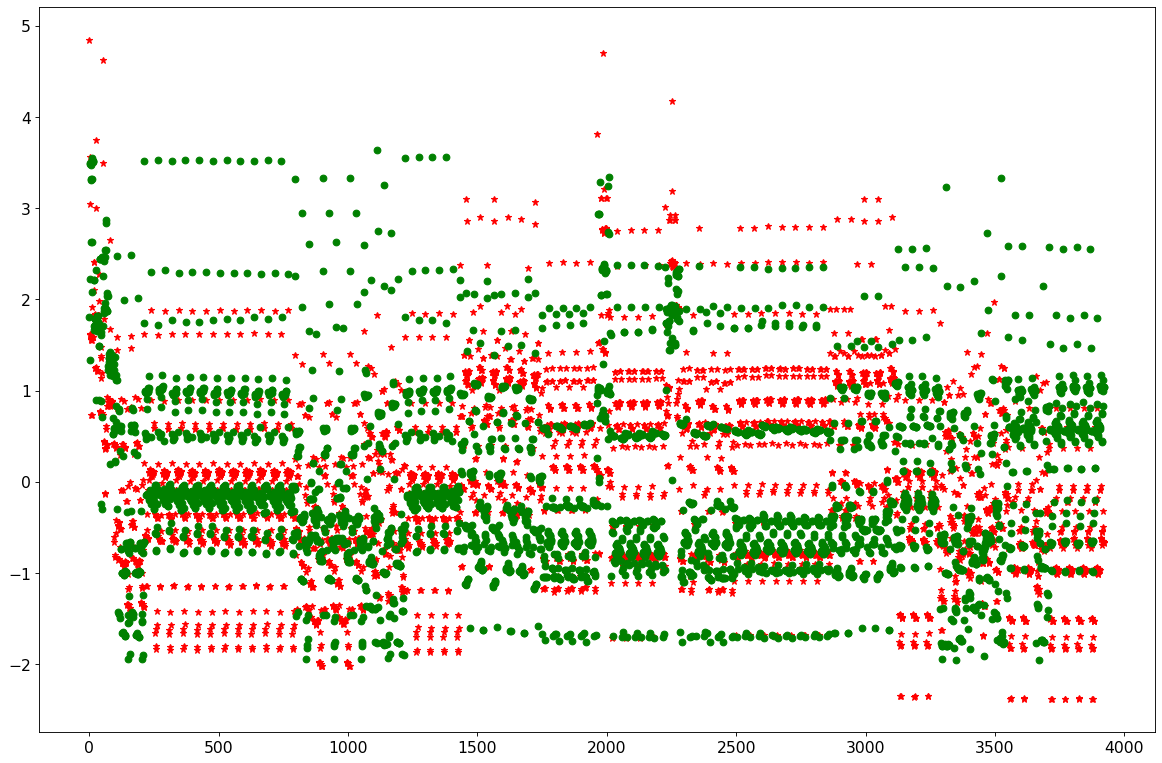

In [104]:
plt.figure(figsize=(18,12))
plt.plot(-zscore(m0), "r*")
plt.plot(zscore(m1), "go")
plt.show()

In [21]:
# pld_seed = df.iloc[seed_indx]["pld"]
# trt_seed = df.iloc[seed_indx]["paths mean"]
pld_seed = 2.0
trt_seed = 1.75
print(pld_seed)
print(trt_seed)
func = curry(get_path_sublist)(pld=pld_seed, trt=trt_seed, diff_pld=0.025, diff_trt=0.025)
dlists, torts = func(path["dist_list"], path["torts"])
print(len(dlists))
path_seed = dlists[0]

2.0
1.75
244


In [44]:
get_dendogram = compose(lambda x: sch.dendrogram(x), 
                        lambda x: sch.linkage(x, method='complete'))

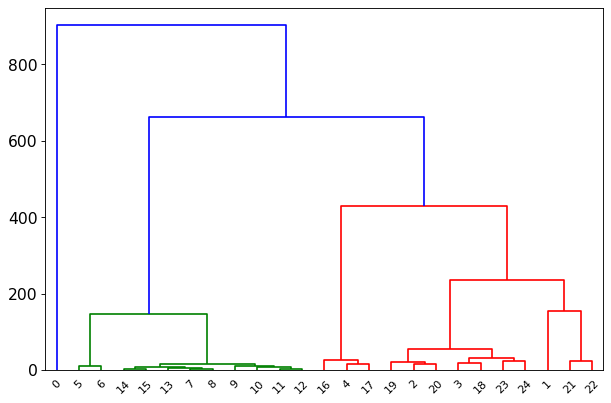

In [59]:
dendogram = get_dendogram(mat3)

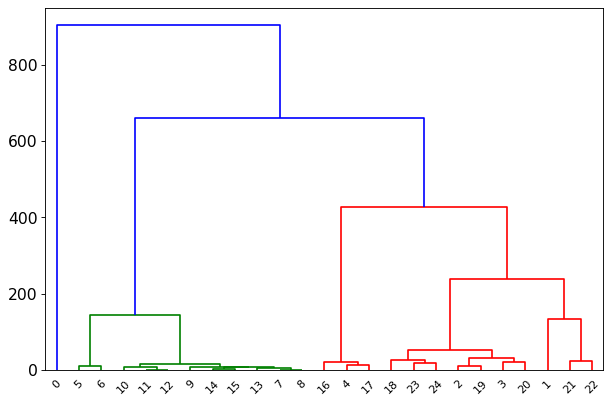

In [61]:
dendogram = get_dendogram(mat2)

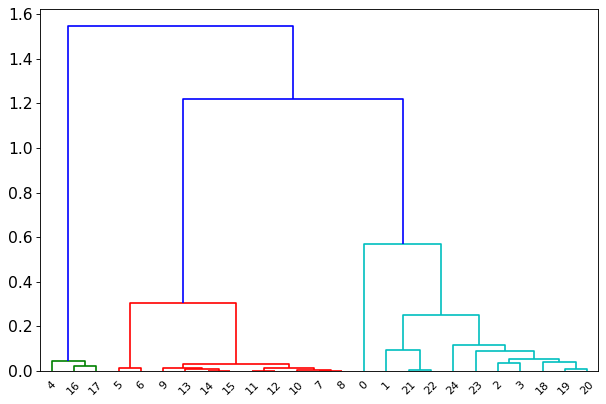

In [48]:
dendogram = get_dendogram(-mat1)

In [22]:
dlists, torts = func(paths[0]["dist_list"], path["torts"])
print(len(dlists))
path_seed = dlists[0]
mat = dmatrix(dlists, dlists)
dendogram = pipe(mat, 
                 lambda x: sch.linkage(x, method='complete'),
                 lambda x: sch.dendrogram(x)
                )

244


KeyboardInterrupt: 

56


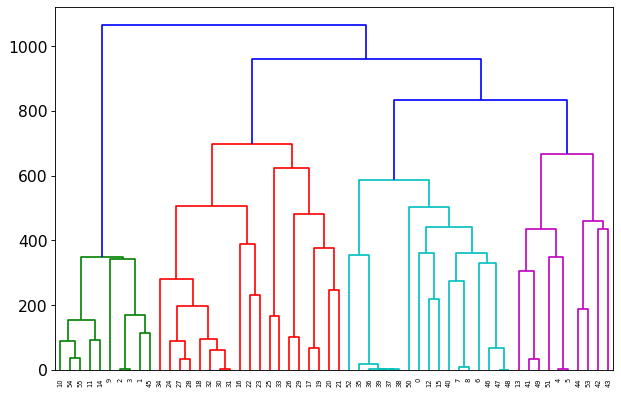

In [127]:
dlists, torts = func(paths[1]["dist_list"], path["torts"])
print(len(dlists))

path_seed = dlists[0]

mat = dmatrix(dlists, dlists)

dendogram = pipe(mat, 
                 lambda x: sch.linkage(x, method='complete'),
                 lambda x: sch.dendrogram(x)
                )

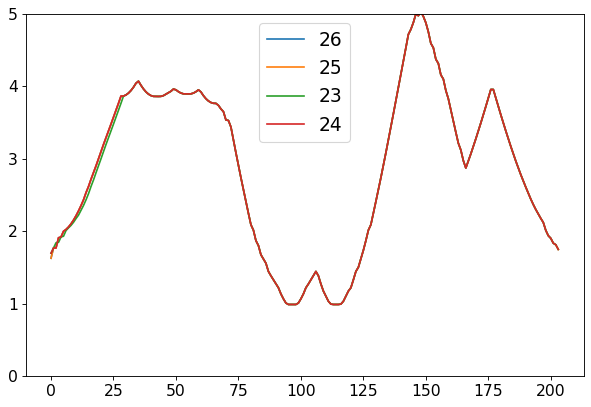

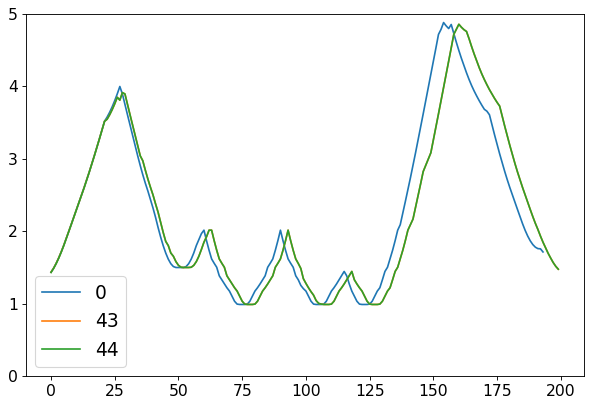

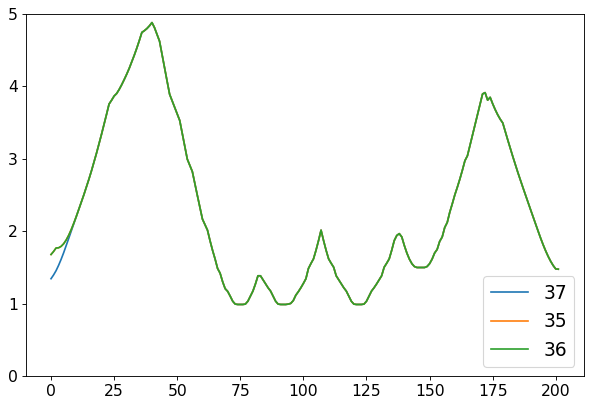

In [121]:
plt.plot(dlists[26])
plt.plot(dlists[25])
plt.plot(dlists[23])
plt.plot(dlists[24])
plt.ylim([0.0, 5.0])
plt.legend([26, 25, 23, 24])
plt.show()

plt.plot(dlists[0])
plt.plot(dlists[43])
plt.plot(dlists[44])
plt.ylim([0.0, 5.0])
plt.legend([0, 43, 44])
plt.show()

plt.plot(dlists[37])
plt.plot(dlists[36])
plt.plot(dlists[36])
plt.ylim([0.0, 5.0])
plt.legend([37, 35, 36])
plt.show()


In [73]:
%%time
ix = 0
dists1, torts1 = func(paths[ix]['dist_list'], paths[ix]['torts'])
print(len(torts1))
ix = 1
dists2, torts2 = func(paths[ix]['dist_list'], paths[ix]['torts'])
print(len(torts2))

639
121
CPU times: user 90.5 ms, sys: 947 µs, total: 91.4 ms
Wall time: 91.2 ms


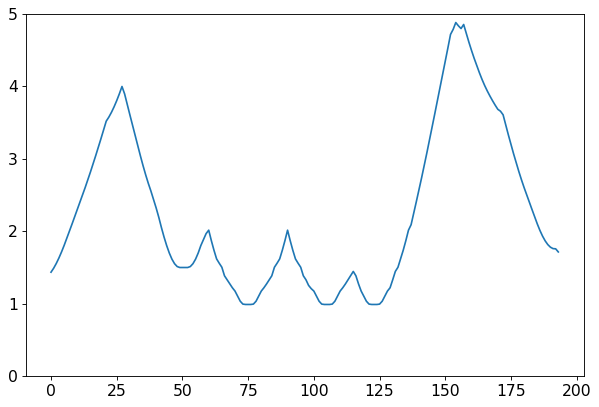

In [106]:
plt.plot(path_seed)
plt.ylim([0.0, 5.0])
plt.show()

In [76]:
%%time
ix = 0
dists1, torts1 = func(paths[ix]['dist_list'], paths[ix]['torts'])
print(len(torts1))
mat1 = dmatrix(dists1, dists1)
dendogram = pipe(mat1, 
                 lambda x: sch.linkage(x, method='complete'),
                 lambda x: sch.dendrogram(x)
                )

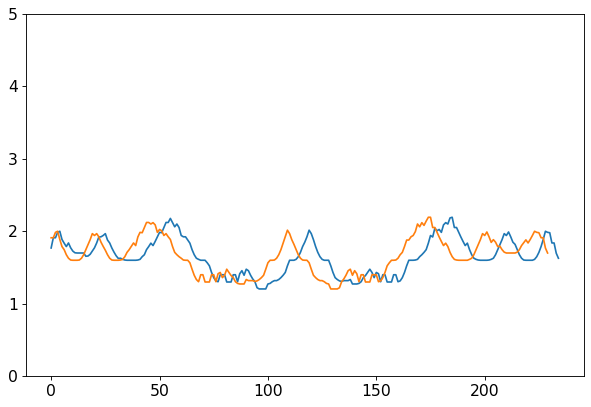

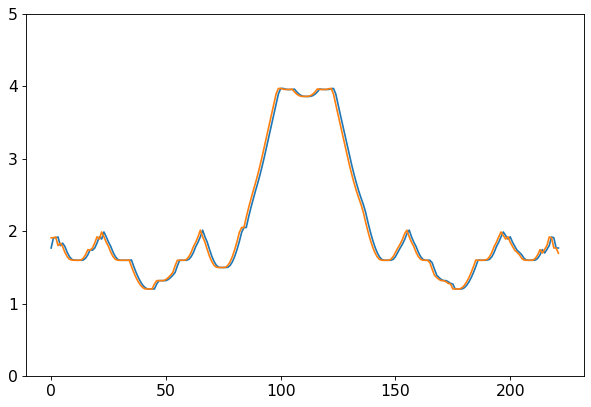

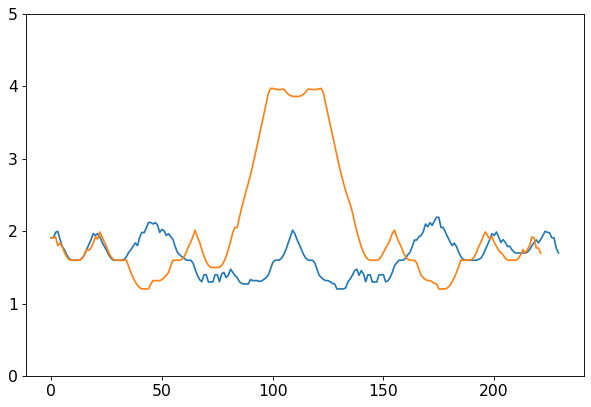

In [29]:
plt.plot(dists1[0])
plt.plot(dists1[11])
plt.ylim([0.0, 5.0])
plt.show()

plt.plot(dists1[22])
plt.plot(dists1[21])
plt.ylim([0.0, 5.0])
plt.show()

plt.plot(dists1[11])
plt.plot(dists1[21])
plt.ylim([0.0, 5.0])
plt.show()

# scores = MDS(n_components=2, dissimilarity="precomputed").fit_transform(mat1)
# plt.scatter(scores[:,0], scores[:,1])
# plt.colorbar()
# plt.show()

In [30]:
%%time
dlist = []
nlist = []
flist = []
for ix, path in enumerate(paths[:10]):
    d, t = func(path['dist_list'], path['torts'])
    dlist += d
    flist += [ciflist_paths[indxs[ix]]]*len(t)
    nlist.append(len(t))
    
    
d_trgt = dlist[0]
distances = []
for d in dlist:
    distances.append(dtw_distance(d_trgt, d))

CPU times: user 16 s, sys: 398 ms, total: 16.4 s
Wall time: 16.7 s


target structure: BECff-[1,0,0]-L-0.379015_0-U-0.810225_0-ss-17.8292106027

farthest structure: CHAff-[1,0,1]-L-0.335274_0-U-0.335461_0-ss-18.3566388438


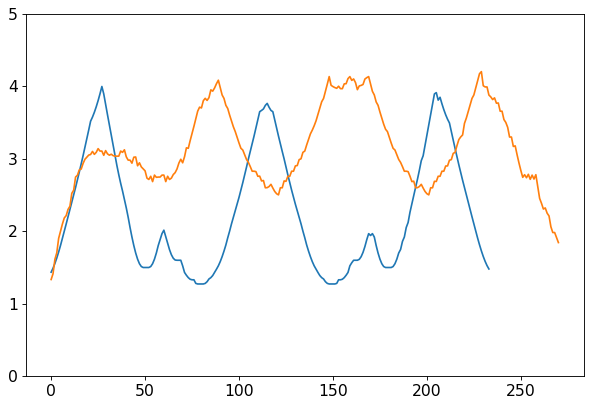

closest structure: BOGff-[0,1,0]-L-0.083414_0-U-0.916667_0-ss-17.16021641


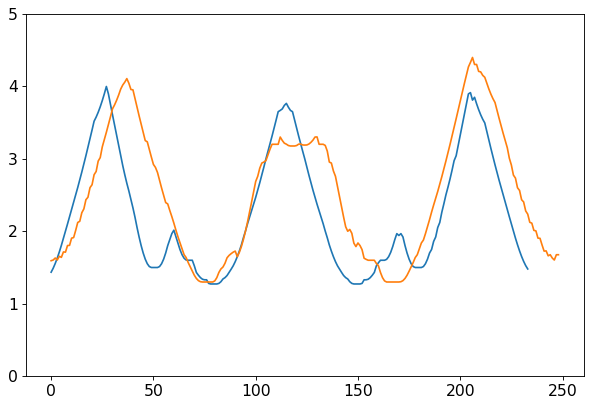

In [31]:
print("target structure: {}\n".format(flist[0]))

ix = np.argmax(distances[17:])+17
print("farthest structure: {}".format(flist[ix]))
plt.plot(dlist[0])
plt.plot(dlist[ix])
plt.ylim([0.0, 5.0])
plt.show()


ix = np.argmin(distances[17:])+17
print("closest structure: {}".format(flist[ix]))
plt.plot(dlist[0])
plt.plot(dlist[ix])
plt.ylim([0.0, 5.0])
plt.show()

